The goal of this project is to build a classification model able to predict a race winner based on F1 drivers' tweets. Tweets were gathered through seasons 2017-2023 (still ongoing).

**Drivers:**
*   There are 20 drivers (in 10 teams), usually with 2-3 drivers changing between seasons
*   I chose those drivers who participated in at least 3 of those seasons and have a Twitter account (and a fairly active one)

**Races:**
*   I excluded races won by non-Twitter users
*   For each race date, I gathered tweets from -1 day and +2 days (3 full days in total)  --> so that 1) tweets posted later would be included and 2) since Qualification takes place a day before the race, it could be the case that for some drivers qualifying as the highest could almost always mean a race win

# Install and import

In [ ]:
! pip3 install snscrape

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 5.1 MB/s eta 0:00:00


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.8 MB/s eta 0:00:00


In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.0 MB/s eta 0:00:00


In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 20.0 MB/s eta 0:00:00


In [ ]:
import datetime
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
import pickle
import re
import random
import matplotlib.pyplot as plt
import torch
import string
import warnings
warnings.filterwarnings('ignore')

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import TextClassificationPipeline
import evaluate
from datasets import load_dataset

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Data preparation

In [ ]:
driver_nick = ['Max33Verstappen', 'Charles_Leclerc', 'SChecoPerez', 'GeorgeRussell63',
               'Carlossainz55', 'LewisHamilton', 'LandoNorris', 'OconEsteban',
                'KevinMagnussen', 'danielricciardo', 'alo_oficial', 'PierreGASLY',
                'alex_albon', 'lance_stroll', 'SchumacherMick', 'NicholasLatifi', 'Anto_Giovinazzi']

In [ ]:
race_data = {'Bahrain': [('05/03/23', 'Max33Verstappen'), ('20/03/22', 'Charles_Leclerc'), ('28/03/21', 'LewisHamilton'), ('29/11/20', 'LewisHamilton'), ('31/03/19', 'LewisHamilton')],
             'Emilia Romanga': [('18/04/21', 'Max33Verstappen'), ('01/11/20', 'LewisHamilton')],
             'Portugal': [('02/05/21', 'LewisHamilton'), ('25/10/20', 'LewisHamilton')],
             'Spain': [('04/06/23', 'Max33Verstappen'), ('22/05/22', 'Max33Verstappen'), ('09/05/21', 'LewisHamilton'), ('16/08/20', 'LewisHamilton'), ('12/05/19', 'LewisHamilton'), ('13/05/18', 'LewisHamilton'), ('14/05/17', 'LewisHamilton')],
             'Monaco': [('28/05/23', 'Max33Verstappen'), ('29/05/22', 'SChecoPerez'), ('23/05/21', 'Max33Verstappen'), ('26/05/19', 'LewisHamilton'), ('27/05/18', 'danielricciardo')],
             'Azerbaijan': [('30/04/23', 'SChecoPerez'), ('12/06/22', 'Max33Verstappen'), ('06/06/21', 'SChecoPerez'), ('29/04/18', 'LewisHamilton'), ('25/06/17', 'danielricciardo')],
             'France': [('24/07/22', 'Max33Verstappen'), ('20/06/21', 'Max33Verstappen'), ('23/06/19', 'LewisHamilton'), ('24/06/18', 'LewisHamilton')],
             'Styria': [('27/06/21', 'Max33Verstappen'), ('12/07/20', 'LewisHamilton')],
             'Austria': [('10/07/22', 'Charles_Leclerc'), ('04/07/21', 'Max33Verstappen'), ('30/06/19', 'Max33Verstappen'), ('01/07/18', 'Max33Verstappen')],
             'Great Britain': [('03/07/22', 'Carlossainz55'), ('18/07/21', 'LewisHamilton'), ('02/08/20', 'LewisHamilton'), ('14/07/19','LewisHamilton'), ('16/07/17', 'LewisHamilton')],
             'Hungary': [('31/07/22', 'Max33Verstappen'), ('01/08/21', 'OconEsteban'), ('19/07/20', 'LewisHamilton'), ('04/08/19', 'LewisHamilton'), ('29/07/18', 'LewisHamilton')],
             'Belgium': [('28/08/22', 'Max33Verstappen'), ('29/08/21', 'Max33Verstappen'), ('30/08/20', 'LewisHamilton'), ('01/09/19', 'Charles_Leclerc'), ('27/08/17', 'LewisHamilton')],
             'Italy': [('24/04/22', 'Max33Verstappen'), ('12/09/21', 'danielricciardo'), ('06/09/20', 'PierreGASLY'), ('08/09/19', 'Charles_Leclerc'), ('02/09/18', 'LewisHamilton'), ('03/09/17', 'LewisHamilton')],
             'Russia': [('26/09/21', 'LewisHamilton'), ('29/09/19', 'LewisHamilton'), ('30/09/18', 'LewisHamilton')],
             'USA': [('23/10/22', 'Max33Verstappen'), ('24/10/21', 'Max33Verstappen'), ('22/10/17', 'LewisHamilton')],
             'Mexico': [('30/10/22', 'Max33Verstappen'), ('07/11/21', 'Max33Verstappen'), ('27/10/19', 'LewisHamilton'), ('28/10/18', 'Max33Verstappen'), ('29/10/17', 'Max33Verstappen')],
             'Brazil': [('13/11/22', 'GeorgeRussell63'), ('14/11/21', 'LewisHamilton'), ('17/11/19', 'Max33Verstappen'), ('11/11/18', 'LewisHamilton')],
             'Abu Dhabi': [('20/11/22', 'Max33Verstappen'), ('12/12/21', 'Max33Verstappen'), ('13/12/20', 'Max33Verstappen'), ('01/12/19', 'LewisHamilton'), ('25/11/18', 'LewisHamilton')],
             'Japan': [('09/10/22', 'Max33Verstappen'), ('07/10/18', 'LewisHamilton'), ('08/10/17', 'LewisHamilton')],
             'Singapore': [('02/10/22', 'SChecoPerez'), ('16/09/18', 'LewisHamilton'), ('17/09/17', 'LewisHamilton')],
             'China': [('14/04/19', 'LewisHamilton'), ('15/04/18', 'danielricciardo'), ('09/04/17', 'LewisHamilton')],
             'Germany': [('28/07/19', 'Max33Verstappen'), ('22/07/18', 'LewisHamilton')],
             'Canada': [('18/06/23', 'Max33Verstappen'), ('19/06/22', 'Max33Verstappen'), ('09/06/19', 'LewisHamilton'), ('11/06/17', 'LewisHamilton')],
             'Saudi Arabia': [('19/03/23', 'SChecoPerez'), ('27/03/22', 'Max33Verstappen')],
             'Australia': [('02/04/23', 'Max33Verstappen'), ('10/04/22', 'Charles_Leclerc')],
             'USA: Miami': [('07/05/23', 'Max33Verstappen'), ('08/05/22', 'Max33Verstappen')],
             'Netherlands': [('04/09/22', 'Max33Verstappen'), ('05/09/21', 'Max33Verstappen')]}

In [ ]:
def get_race_name(race, val):
  return str(race) + '_' + str(val[0][6:8]) #for example: Portugal_21


def get_dates(date):
  race_date = datetime.datetime.strptime(date, "%d/%m/%y")
  start = race_date + datetime.timedelta(days=-1)
  end = race_date + datetime.timedelta(days=2)
  return datetime.datetime.strftime(start,'%Y-%m-%d'), datetime.datetime.strftime(end,'%Y-%m-%d')

## Data gathering

In [ ]:
def get_driver_tweets(username, start, end):
  tweets_driver = []
  # returns a list of tweets for a given user in a given time window
  query = f" from:{username} until:{end} since:{start}"
  for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
        tweets_driver.append([tweet.user.username, tweet.date, tweet.rawContent, tweet.lang, tweet.likeCount])
  return tweets_driver



def get_race_tweets(data, race_place, save=False, PATH=""):
  final_df = pd.DataFrame()
  # returns a df of tweets for all races in this place and all drivers
  for race in data[race_place]:
    race_df = pd.DataFrame()
    drivers_tweets = []
    start, end = get_dates(race[0])
    # get data for all drivers for this year
    for driver in driver_nick:
      drivers_tweets.extend(get_driver_tweets(driver, start, end))

    race_df = race_df.append(pd.DataFrame([get_race_name(race_place, race) for i in range(len(drivers_tweets))]))
    race_df = pd.concat((race_df, pd.DataFrame(drivers_tweets)), axis = 1)
    race_df.columns = ['race', 'username', 'date', 'tweet', 'language', 'like_count']
    race_df['winner'] = race_df.apply(lambda row : 1 if row.username == race[1] else 0, axis = 1)

    final_df = pd.concat((final_df, race_df))

  if save:
    final_df.to_csv(PATH + race_place + ".csv")

  return final_df

In [ ]:
# for a single key in race_data (one race place)
aus = get_race_tweets(race_data, "Australia")
aus.head()

<ipython-input-180-017d576ca5da>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  race_df = race_df.append(pd.DataFrame([get_race_name(race_place, race) for i in range(len(drivers_tweets))]))
<ipython-input-180-017d576ca5da>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  race_df = race_df.append(pd.DataFrame([get_race_name(race_place, race) for i in range(len(drivers_tweets))]))


,race,username,date,tweet,language,like_count,winner
0,Australia_23,Max33Verstappen,2023-04-02 09:40:45+00:00,Back where we want to be☝️\n\nToday completes ...,en,28207,1
1,Australia_23,Max33Verstappen,2023-04-01 07:16:17+00:00,Very happy with my Quali and to be on Pole her...,en,28463,1
2,Australia_23,Charles_Leclerc,2023-04-01 09:11:32+00:00,Didn’t drive well enough and a messy Q3 means ...,en,48524,0
3,Australia_23,SChecoPerez,2023-04-03 15:05:28+00:00,¡Diseña el casco que usaré para el GP de Méxic...,es,16197,0
4,Australia_23,SChecoPerez,2023-04-02 10:31:50+00:00,What a crazy race! At the end we had a good re...,en,43527,0


In [ ]:
# for the whole dictionary ( mins)
# FULL_DF = pd.DataFrame()
# for r in race_data.keys():
#   res = get_race_tweets(race_data, r, save=True, PATH="")
#   FULL_DF = pd.concat((FULL_DF, res))
# FULL_DF.to_csv("raw_race_data.csv", index = False)

## Cleaning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = "/content/drive/MyDrive/NLP_Cog/F1_project/"

In [ ]:
raw_data = pd.read_csv(PATH + "raw_race_data.csv")
raw_data.reset_index(inplace = True, drop = True)
raw_data.drop(raw_data.columns[0], axis=1, inplace = True)
raw_data.iloc[1120:1130] # 5212 rows

,race,username,date,tweet,language,like_count,winner
1120,Azerbaijan_22,LewisHamilton,2022-06-13 17:57:18+00:00,here's the photo btw https://t.co/PPECtdgHNu,en,180773,0
1121,Azerbaijan_22,LewisHamilton,2022-06-12 20:35:11+00:00,"Even when it’s painful, still we rise. Thanks ...",en,126923,0
1122,Azerbaijan_22,LandoNorris,2022-06-12 18:04:56+00:00,"Always pushing to the limit, but we got the po...",en,46233,0
1123,Azerbaijan_22,LandoNorris,2022-06-12 05:20:00+00:00,BEAUTY,en,15759,0
1124,Azerbaijan_22,LandoNorris,2022-06-12 05:19:49+00:00,RACE DAY,en,23067,0
1125,Azerbaijan_22,LandoNorris,2022-06-11 17:41:07+00:00,"p11, lap was good, I just didn't get a slipstr...",en,16984,0
1126,Azerbaijan_22,OconEsteban,2022-06-13 22:24:21+00:00,👋 🇨🇦 https://t.co/m4ZCnlxAfi,qme,13105,0
1127,Azerbaijan_22,OconEsteban,2022-06-12 15:26:30+00:00,Not the easiest of races but still a point on ...,en,2553,0
1128,Azerbaijan_22,OconEsteban,2022-06-12 06:10:50+00:00,@Cricad49 @AlpineF1Team Merci 🙏,fr,231,0
1129,Azerbaijan_22,OconEsteban,2022-06-11 15:48:08+00:00,Yellow flags again stopping us at the end ther...,en,2254,0


In [ ]:
# https://drive.google.com/open?id=1G1vIkkbqPBYPKHcQ8qy0G2zkoab2Qv4v <- EmojiDict
with open(PATH + 'Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

# instead of removing emojis, they will be converted into words
def convert_emojis_to_word(text):
    for emo in Emoji_Dict:
        text = re.sub(r'('+emo+')', "_".join(Emoji_Dict[emo].replace(",","").replace(":","").split()), text)
    return text


def clean_tweets(tweet):
  tweet = convert_emojis_to_word(tweet)
  # remove handles and links
  USER_REGEX = r"@([^ ]+)"
  URL_REGEX = r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)"
  tweet = re.sub(USER_REGEX, "", tweet)
  tweet = re.sub(URL_REGEX, "", tweet)
  tweet = " ".join(tweet.split()) #remove multiple spaces and tabs
  return tweet


In [ ]:
raw_data['clean_tweet'] = raw_data.apply(lambda row : clean_tweets(row.tweet), axis = 1)
raw_data.iloc[1120:1130]

,race,username,date,tweet,language,like_count,winner,clean_tweet
1120,Azerbaijan_22,LewisHamilton,2022-06-13 17:57:18+00:00,here's the photo btw https://t.co/PPECtdgHNu,en,180773,0,here's the photo btw
1121,Azerbaijan_22,LewisHamilton,2022-06-12 20:35:11+00:00,"Even when it’s painful, still we rise. Thanks ...",en,126923,0,"Even when it’s painful, still we rise. Thanks ..."
1122,Azerbaijan_22,LandoNorris,2022-06-12 18:04:56+00:00,"Always pushing to the limit, but we got the po...",en,46233,0,"Always pushing to the limit, but we got the po..."
1123,Azerbaijan_22,LandoNorris,2022-06-12 05:20:00+00:00,BEAUTY,en,15759,0,BEAUTY
1124,Azerbaijan_22,LandoNorris,2022-06-12 05:19:49+00:00,RACE DAY,en,23067,0,RACE DAY
1125,Azerbaijan_22,LandoNorris,2022-06-11 17:41:07+00:00,"p11, lap was good, I just didn't get a slipstr...",en,16984,0,"p11, lap was good, I just didn't get a slipstr..."
1126,Azerbaijan_22,OconEsteban,2022-06-13 22:24:21+00:00,👋 🇨🇦 https://t.co/m4ZCnlxAfi,qme,13105,0,waving_hand 🇨🇦
1127,Azerbaijan_22,OconEsteban,2022-06-12 15:26:30+00:00,Not the easiest of races but still a point on ...,en,2553,0,Not the easiest of races but still a point on ...
1128,Azerbaijan_22,OconEsteban,2022-06-12 06:10:50+00:00,@Cricad49 @AlpineF1Team Merci 🙏,fr,231,0,Merci folded_hands
1129,Azerbaijan_22,OconEsteban,2022-06-11 15:48:08+00:00,Yellow flags again stopping us at the end ther...,en,2254,0,Yellow flags again stopping us at the end ther...


In [ ]:
#raw_data.to_csv("clean_data.csv")
raw_data = pd.read_csv(PATH + "clean_data.csv")
raw_data.reset_index(inplace = True, drop = True)
raw_data.drop(raw_data.columns[0], axis=1, inplace = True)

## Splitting

In [ ]:
raw_data['race'].value_counts()

Japan_17         127
Italy_18         106
Austria_18       103
France_18        100
Italy_17         100
                ... 
Italy_22          27
Spain_23          26
Canada_17         26
USA: Miami_23     26
Portugal_21        7
Name: race, Length: 100, dtype: int64

In [ ]:
random.seed(555)
test_idx = random.sample(raw_data['race'].unique().tolist(), k =10) # save 10% of races for testing

In [ ]:
# splitting the data
test_data = raw_data[raw_data['race'].isin(test_idx)]
train_data = raw_data.drop(index=test_data.index)

test_data.reset_index(inplace = True, drop = True)
train_data.reset_index(inplace = True, drop = True)

# Classification models

## Bag of Words NN

In [ ]:
data_train = train_data.clean_tweet
labels_train = train_data.winner
data_test = test_data.clean_tweet
labels_test = test_data.winner

In [ ]:
# remove NANs (after cleaning)
drop_train = data_train[data_train.isna()].index.tolist()
data_train = data_train.drop(index=drop_train)
labels_train = labels_train.drop(index=drop_train)

drop_test = data_test[data_test.isna()].index.tolist()
data_test = data_test.drop(index=drop_test)
labels_test = labels_test.drop(index=drop_test)
test_data = test_data.drop(index=drop_test)

In [ ]:
#BOW encoding
def encode_inputs(encoder, X):
    enc = encoder()
    enc.fit(X)
    return enc.transform(X)


vectorizer = CountVectorizer(ngram_range = (1,3)).fit(data_train.apply(lambda x: np.str_(x)))
X_train = vectorizer.transform(data_train.apply(lambda x: np.str_(x))).toarray()
y_train = encode_inputs(LabelEncoder, labels_train)

X_test = vectorizer.transform(data_test.apply(lambda x: np.str_(x))).toarray()
y_test = encode_inputs(LabelEncoder, labels_test)

In [ ]:
# building the model
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

early_stopping = EarlyStopping()
bow_model = model.fit(X_train,
                      y_train,
                      epochs=15,
                      verbose=1,
                      validation_split=0.1,
                      callbacks=[early_stopping])

Epoch 1/15
128/128 [==============================] - 15s 95ms/step - loss: 0.4822 - accuracy: 0.9202 - val_loss: 0.4286 - val_accuracy: 0.9229
Epoch 2/15
128/128 [==============================] - 10s 75ms/step - loss: 0.3070 - accuracy: 0.9332 - val_loss: 0.3847 - val_accuracy: 0.9229
Epoch 3/15
128/128 [==============================] - 13s 102ms/step - loss: 0.2381 - accuracy: 0.9461 - val_loss: 0.3561 - val_accuracy: 0.9229
Epoch 4/15
128/128 [==============================] - 11s 88ms/step - loss: 0.1934 - accuracy: 0.9616 - val_loss: 0.3345 - val_accuracy: 0.9251
Epoch 5/15
128/128 [==============================] - 13s 103ms/step - loss: 0.1627 - accuracy: 0.9716 - val_loss: 0.3191 - val_accuracy: 0.9273
Epoch 6/15
128/128 [==============================] - 10s 80ms/step - loss: 0.1401 - accuracy: 0.9767 - val_loss: 0.3070 - val_accuracy: 0.9273
Epoch 7/15
128/128 [==============================] - 9s 69ms/step - loss: 0.1231 - accuracy: 0.9819 - val_loss: 0.2972 - val_accuracy

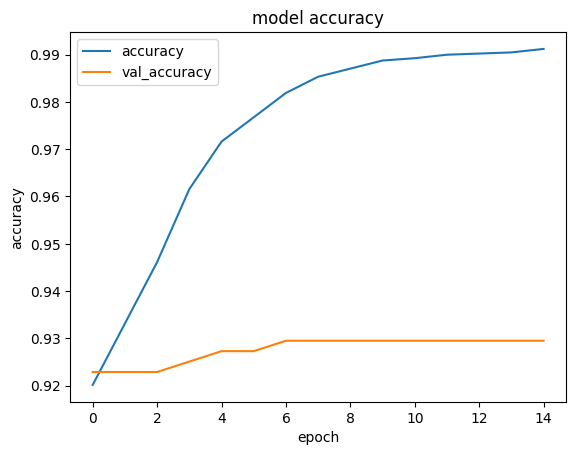

In [ ]:
# show accuracy
plt.plot(bow_model.history['accuracy'])
plt.plot(bow_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

In [ ]:
score, acc = model.evaluate(X_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

19/19 [==============================] - 3s 169ms/step - loss: 0.2009 - accuracy: 0.9447
Test score: 0.2008776217699051
Test accuracy: 0.9447323083877563


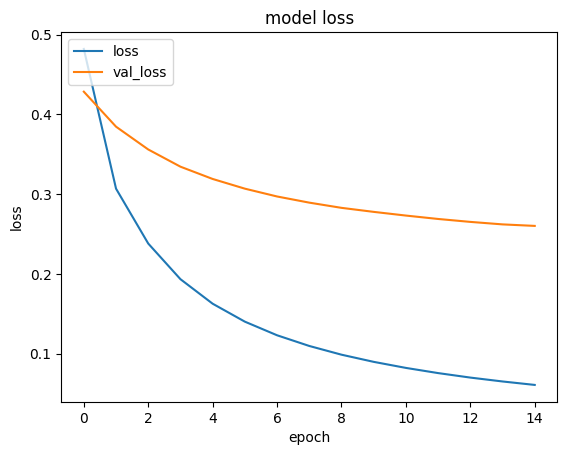

In [ ]:
# show loss
plt.plot(bow_model.history['loss'])
plt.plot(bow_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [ ]:
# predictions
pred_probs = model.predict(X_test)
pred_labels = [0 if x < 0.5 else 1 for x in pred_probs]
print(pred_labels)

19/19 [==============================] - 2s 91ms/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
Counter(pred_labels)

Counter({0: 572, 1: 7})

This model is very probably overfitting (as the accuracy on the validation set is not improving), and overall not the best. Despite it's accuracy on the test set being calculated as 0.94, this metric is not very useful. As most tweets in the data come from non-winners, the model can achieve high accuracy by virtually predicting only 0s.

To evaluate the model, I will group the test data per race, make the driver with most 1s as a predicted winner and compare it with the real winner.

**NOTE:** It actually turned out that some races (mostly from 2017) have winners that did not tweet anything! Not to lose (already kind of scarce) data, those races would be labelled as "no winner". That will also be the case when the model predicts 0s for all tweets in one race.

In [ ]:
def create_eval_data(test_data, pred_labels):
  eval_data = pd.DataFrame()
  new_data = test_data
  new_data['pred_label'] = pred_labels
  # for each race get the true winner
  for name, group in new_data.groupby('race'):
    if len(group[group['winner'] == 1].index) == 0:
      true = "no winner"
    else:
      true = str(group[group['winner'] == 1].username.iloc[0])

    # set the predicted winner as driver with most tweets labeled as 1
    driver, pred_sum = "no winner", 0
    for driver_name, sub_group in group.groupby('username'):
      no_tweets = sub_group['pred_label'].sum()
      if no_tweets > pred_sum:
        driver, pred_sum = driver_name, no_tweets

    eval_data = eval_data.append({"race": name, "true_winner": true, "pred_winner": driver}, ignore_index=True)

  return eval_data

In [ ]:
eval_data = create_eval_data(test_data, pred_labels)
eval_data

,race,true_winner,pred_winner
0,Austria_18,Max33Verstappen,Max33Verstappen
1,Austria_22,Charles_Leclerc,no winner
2,Azerbaijan_18,LewisHamilton,LewisHamilton
3,Brazil_18,LewisHamilton,LewisHamilton
4,Canada_19,LewisHamilton,no winner
5,Italy_21,danielricciardo,no winner
6,Monaco_18,danielricciardo,no winner
7,Monaco_19,LewisHamilton,LewisHamilton
8,Monaco_23,Max33Verstappen,Max33Verstappen
9,Spain_19,LewisHamilton,no winner


Those results don't look too bad: 5/10 winning drivers were predicted correctly, and also 5/10 predictions were drivers (and not "no winner" = only 0s). As I will also mention later, drivers who won the most (in this dataset) were Lewis Hamilton and Max Verstappen. So the model, instead of learning the pattern for 'winning' tweets, could learn patterns for tweets of those two drivers. Here, however, this does not seem to be the case - as only 3/5 of Hamilton's wins were predicted as his.

## Naive Bayes (with TF-IDF)

In [ ]:
# the encoding and vectorizer stay the same as above
def encode_inputs(encoder, X):
    enc = encoder()
    enc.fit(X)
    return enc.transform(X)

vectorizer = CountVectorizer(ngram_range = (1,3)).fit(data_train.apply(lambda x: np.str_(x)))
X_train = vectorizer.transform(data_train.apply(lambda x: np.str_(x))).toarray()
y_train = encode_inputs(LabelEncoder, labels_train)

X_test = vectorizer.transform(data_test.apply(lambda x: np.str_(x))).toarray()
y_test = encode_inputs(LabelEncoder, labels_test)

In [ ]:
# with TF-IDF it works much worse
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.fit_transform(X_test)

In [ ]:
model = MultinomialNB().fit(X_train, y_train)
pred_labels = model.predict(X_test)
Counter(pred_labels)

Counter({0: 572, 1: 7})

In [ ]:
print("accuracy: ", accuracy_score(y_test, pred_labels))
confusion_matrix(y_test, pred_labels)

accuracy:  0.9412780656303973


array([[540,   2],
       [ 32,   5]])

In [ ]:
eval_data = create_eval_data(test_data, pred_labels)
eval_data

,race,true_winner,pred_winner
0,Austria_18,Max33Verstappen,Max33Verstappen
1,Austria_22,Charles_Leclerc,no winner
2,Azerbaijan_18,LewisHamilton,LewisHamilton
3,Brazil_18,LewisHamilton,no winner
4,Canada_19,LewisHamilton,no winner
5,Italy_21,danielricciardo,Max33Verstappen
6,Monaco_18,danielricciardo,no winner
7,Monaco_19,LewisHamilton,LewisHamilton
8,Monaco_23,Max33Verstappen,alo_oficial
9,Spain_19,LewisHamilton,no winner


This model performed worse, predicting correctly only 3/10 winners. (While using the TF-IDF Transformer, all of the predictions were 0s - so even worse.) The previous model, for 2 drivers with most wins - Hamilton and Verstappen - gave only correct predictions or "no winner". Here, that is not the case (Alonso for Verstappen). Although, it is nice to see that not only those two drivers are being predicted as winners (which would be an easy way to overfit).

## Logistic Regression

In [ ]:
log_reg = LogisticRegression()

# on CountVectorizer data
log_reg.fit(X_train, y_train)
pred_labels = log_reg.predict(X_test)
print("accuracy: ", accuracy_score(y_test, pred_labels))
print(Counter(pred_labels))
eval_data = create_eval_data(test_data, pred_labels)
eval_data

accuracy:  0.9430051813471503
Counter({0: 561, 1: 18})


,race,true_winner,pred_winner
0,Austria_18,Max33Verstappen,LewisHamilton
1,Austria_22,Charles_Leclerc,no winner
2,Azerbaijan_18,LewisHamilton,LewisHamilton
3,Brazil_18,LewisHamilton,LewisHamilton
4,Canada_19,LewisHamilton,LewisHamilton
5,Italy_21,danielricciardo,LewisHamilton
6,Monaco_18,danielricciardo,Carlossainz55
7,Monaco_19,LewisHamilton,LewisHamilton
8,Monaco_23,Max33Verstappen,Max33Verstappen
9,Spain_19,LewisHamilton,LewisHamilton


In [ ]:
# on TF-IDF data
log_reg.fit(X_train_tfidf, y_train)
pred_labels = log_reg.predict(X_test_tfidf)
print("accuracy: ", accuracy_score(y_test, pred_labels))
print(Counter(pred_labels))
eval_data = create_eval_data(test_data, pred_labels)
eval_data

accuracy:  0.9395509499136442
Counter({0: 575, 1: 4})


,race,true_winner,pred_winner
0,Austria_18,Max33Verstappen,no winner
1,Austria_22,Charles_Leclerc,no winner
2,Azerbaijan_18,LewisHamilton,LewisHamilton
3,Brazil_18,LewisHamilton,LewisHamilton
4,Canada_19,LewisHamilton,no winner
5,Italy_21,danielricciardo,no winner
6,Monaco_18,danielricciardo,LewisHamilton
7,Monaco_19,LewisHamilton,no winner
8,Monaco_23,Max33Verstappen,no winner
9,Spain_19,LewisHamilton,no winner


A simple model of logistic regression trained on CountVectorizer data achieved the best score yet - 6/10 correct predictions. However, it is due to the fact that 5/10 true winners in this test dataset are Lewis Hamilton and the model clearly picked up on that pattern (7/10 its predictions were Hamilton). On the bright side, it is worth noticing that as many as 18 tweets were predicted as 1s here. This could mean that the model's decisions are more confident (since the winning driver probably had more than 1 tweet marked as winning, and there were possibly more "contenders" - not just a single tweet predicted as 1 for a whole race).

Logistic regression with TF-IDF performed much worse (2/10 correct predictions and only 3/10 predicted as a driver).
Also, trying regularization did not improve the base model.

## Transformers

In [ ]:
# https://huggingface.co/docs/transformers/training#evaluate

# load my data for training and validation (10%) as a Dataset object
my_dataset = load_dataset("Malekith/twitter_f1")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/Malekith___csv/Malekith--twitter_f1-9baf33ce66fc8dcf/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# tokenize the data
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = my_dataset.map(tokenize_function, batched=True)
train_dataset = tokenized_datasets["train"].shuffle(seed=42)
eval_dataset = tokenized_datasets["validation"].shuffle(seed=42)

Map:   0%|          | 0/3978 [00:00<?, ? examples/s]

Map:   0%|          | 0/560 [00:00<?, ? examples/s]

In [ ]:
# load the model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [ ]:
# set evaluation metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# keep checkpoints
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

# create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.266766,0.937500
2,0.293500,0.285375,0.937500
3,0.293000,0.247410,0.937500


TrainOutput(global_step=1494, training_loss=0.2923603798331346, metrics={'train_runtime': 1340.7744, 'train_samples_per_second': 8.901, 'train_steps_per_second': 1.114, 'total_flos': 3139967334666240.0, 'train_loss': 0.2923603798331346, 'epoch': 3.0})

In [ ]:
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)
model = model.to("cpu")
predictions = pipe(data_test.tolist())

In [ ]:
# transform into 0s and 1s (now it's "LABEL_0": score, "LABEL_1": score for each tweet)
pred_labels = [0 if l[0]['score'] > l[1]['score'] else 1 for l in predictions]
print(Counter(pred_labels))
eval_data = create_eval_data(test_data, pred_labels)
eval_data

Counter({0: 579})


,race,true_winner,pred_winner
0,Austria_18,Max33Verstappen,no winner
1,Austria_22,Charles_Leclerc,no winner
2,Azerbaijan_18,LewisHamilton,no winner
3,Brazil_18,LewisHamilton,no winner
4,Canada_19,LewisHamilton,no winner
5,Italy_21,danielricciardo,no winner
6,Monaco_18,danielricciardo,no winner
7,Monaco_19,LewisHamilton,no winner
8,Monaco_23,Max33Verstappen,no winner
9,Spain_19,LewisHamilton,no winner


I thought I would try to do a nice overkill, using a Transformer model for this kind of problem, but it did not work at all. With high confidence it classified all the tweets as losers.

# Final thoughts

The two best models turned out to be a simple neural net using BOW encoding (5/10) and a basic logistic regression classificator (6/10). The latter also predicted a driver that was not one of the two with most races won, which showed its flexibity (rather than overfitting to those two drivers). Still, the results could have been much better and there are certain issues that probably arised here.


WHAT WERE THE PROBLEMS?

*  too much variability - each driver has a different style and frequency of tweeting, which makes it hard for the model to find a certain pattern that winning tweets could follow
*  unbalanced dataset - only 1 driver is a winner, so there is a major underrepresentation of those tweets


HOW TO FIX THEM?

*  ensamble of models - maybe it would be beneficial to first treat each driver as a label, so a model could learn their "style" of tweets; and later another model could predict the winners on tweets + those somehow encoded information about the drivers (but this is surely an overkill)
*  the dataset could be narrowed - for example each race would only have 1 winner and chosen 4 losers; however that way the amount of data would diminish significantly and the model probably would not be fitted well

# Additional analysis - Word Clouds

In [ ]:
# https://www.datacamp.com/tutorial/wordcloud-python
# prepare "losing" and "winning" tweets for 2 drivers with most wins

max_df = raw_data[raw_data.username == "Max33Verstappen"] #410
win_max = max_df[max_df.winner == 1]['clean_tweet'].tolist() #147
lose_max = max_df[max_df.winner == 0]['clean_tweet'].tolist() #263

lewis_df = raw_data[raw_data.username == "LewisHamilton"] #254
win_lewis = lewis_df[lewis_df.winner == 1]['clean_tweet'].tolist() #157
win_lewis = list(map(str, win_lewis))
lose_lewis = lewis_df[lewis_df.winner == 0]['clean_tweet'].tolist() #97
lose_lewis = list(map(str, lose_lewis))

In [ ]:
def draw_cloud(tweets):
  text = " ".join(tweet for tweet in tweets)

  stopwords = set(STOPWORDS)
  stopwords.update(list(string.ascii_lowercase))

  wc = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  #display
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.show()

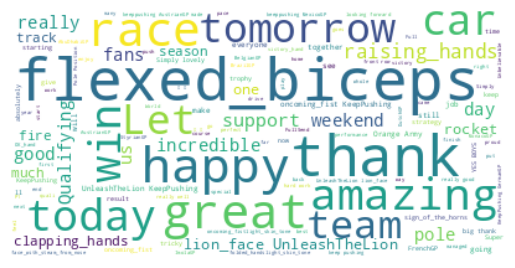

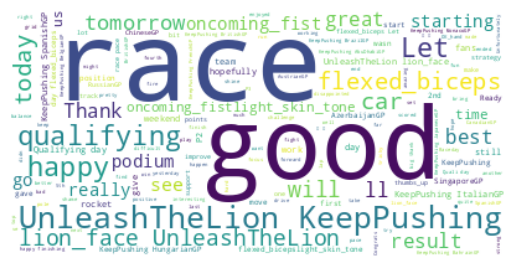

In [ ]:
draw_cloud(win_max)
draw_cloud(lose_max)

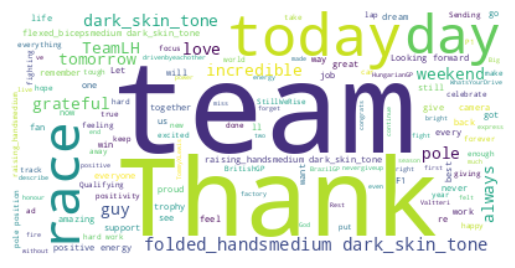

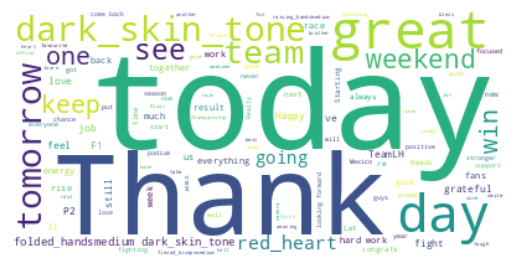

In [ ]:
draw_cloud(win_lewis)
draw_cloud(lose_lewis)

Those word clouds primarly illustrate is actually how confusing it could be to differenciate between tweets posted after a lost and a won race.

For Max Verstappen, emojis like 💪, 🙌 and 👏 dominate after a race he won. For the lost ones, however, 💪 and ✊ appear a lot. This naturally can symbolize prevalence and keeping it together, but their interpretation as a sign of victory is just as well justified. Similarly, Max's signature phrase of "unleashing the lion" seems to be more often used by fans while cheering on him after a win. In the tweets it is contrarily more prominent after not successful races. Furthermore, although words like "great" and "happy" appear more after wins, they are also quite present after loses, alongside with "best" and - biggest of all - "good".

One characteristic trait of Max's winning tweets could be that "thank[s]" is visible there much more. However, this is far from being a decent general feature - looking at Lewis Hamilton's tweets where it is one of the most common words in both sets. The usage of emojis is also similar in comparison. Characteristic for winning tweets could be the words "team" and "grateful"; but those such as "great" or - surprisingly - "win" could be very misleading.